# Basic Usage of `RandomMeas.jl`

This notebook walks through **one complete workflow** of the package – from *sampling* random measurement settings, through *collecting* bit‑string data, to *building* classical shadows and finally *estimating* observables.

We start by importing the package.

In [1]:
using RandomMeas

Next, we define the (total) system size of interest.

In [2]:
N=50;

## Randomized measurement settings

We now sample randomized measurement settings. Here, we parametrize them through single‑qubit (local) random unitaries which are drawn for each qubit independently from the Haar ensemble on $U(2)$. We draw $N_U = 100$ settings. 

In [3]:
NU = 200 # Number of measurement settings
measurement_settings = [LocalUnitaryMeasurementSetting(N) for _ in 1:NU];

## Classical simulation of randomized measurements

Instead of running on actual quantum hardware we here simulate the entire RM protocol on a
weakly‑entangled MPS $\lvert\psi\rangle$ with bond dimension 2.

In [4]:
site_indices = siteinds("Qubit",N)
ψ = random_mps(site_indices, linkdims=2); # state

For each setting we perform $N_M = 400$ projective measurements, yielding a
`MeasurementGroup` container that stores **all** measurement outcomes **and** measurement settings used.

In [5]:
NM=100 # Number of projective measurements per measurement setting
measurement_group = MeasurementGroup(ψ ,measurement_settings,NM);

## Post‑processing


###  Building classical shadows

Now, we start the postprocessing. We first construct classical shadows (reference). Here, "factorized" classical shadows are memory efficient objects (stored as N x 2 x 2 arrays) suitable for large system sizes.

In [6]:
classical_shadows = get_factorized_shadows(measurement_group);

### Estimating the expectation value of an observable

As an example, we construct an observable
$$
O = Z_1 \otimes I_2 \otimes I_3 \otimes X_4 \otimes I_{5\dots N},
$$
and compute

* the shadow estimate $\widehat{\langle O\rangle}$ and its standard error 
* the exact value $\langle O\rangle = \langle\psi\lvert O \rvert\psi\rangle$ . 

In [7]:
ops = ["I" for _ in 1:N]
ops[1] = "Z"
ops[4] = "X"
O=MPO(site_indices,ops);

mean_val, sem_val = real.(get_expect_shadow(O,classical_shadows,compute_sem = true));
exact_val = inner(ψ',O,ψ);

println("Estimated expectation value ⟨O⟩ = $(round(mean_val, digits=2)) ± $(round(sem_val, digits=2))")
println("Exact expectation value of ⟨O⟩ = $(round(exact_val, digits=2))")


Estimated expectation value ⟨O⟩ = -0.24 ± 0.02
Exact expectation value of ⟨O⟩ = -0.3


### Dense classical shadows for small systems

Alternatively, becasue our observable $O$ acts non‑trivially on just two qubits, we can reduce the entire post-processing procedure to effective two-qubit subsystem of interest. To this end, we reduce the data set and construct classical shadows on the two-qubit subsystem. This allows to generate dense classical shadows (stored $2^2 \times 2^2$ dense matrices) which allow for very fast post-processing. Since these dense classical shadows are not memory efficient (in a general $N$ qubit system, they are a $2^N \times 2^N$ dense matrix), this approach works for (sub-)systems consisting of up to ~15 qubits.

In [8]:
subsystem = [1,4]
reduced_group = reduce_to_subsystem(measurement_group,subsystem);
reduced_classical_shadows = get_dense_shadows(reduced_group);

We use the reduced classical shadows to estimat the expectation value of the reduced operator O. We obtain the same value as before.

In [9]:
ops = ["Z","X"]
reduced_O=MPO([site_indices[1],site_indices[4]],ops);

mean_val, sem_val = real.(get_expect_shadow(reduced_O,reduced_classical_shadows,compute_sem = true));
exact_val = inner(reduced_O,reduce_to_subsystem(ψ,[1,4]));
println("Estimated expectation value ⟨O⟩ = $(round(mean_val, digits=2)) ± $(round(sem_val, digits=2))")
println("Exact expectation value of ⟨O⟩ = $(round(exact_val, digits=2))")


Estimated expectation value ⟨O⟩ = -0.24 ± 0.04
Exact expectation value of ⟨O⟩ = -0.3


In [10]:
paulis = ["X","Y","Z"]
op_1 = [[s,"I"] for s in paulis]
op_2 = [["I",s] for s in paulis]
op_3 = [[s1,s2] for s1 in paulis for s2 in paulis]
op_list = [op_1;op_2]
op_list = [op_list;op_3]
n_op = length(op_list)
mean_val = zeros(Float64,n_op)
sem_val = zeros(Float64,n_op)
exact_val = zeros(Float64,n_op)
for k in 1:n_op
    reduced_O=MPO(ComplexF64,[site_indices[1],site_indices[4]],op_list[k]);
    mean_val[k], sem_val[k] = real.(get_expect_shadow(reduced_O,reduced_classical_shadows,compute_sem = true));
    exact_val[k] = real(inner(reduced_O,reduce_to_subsystem(ψ,[1,4])));
end


In [11]:
using Plots
using LaTeXStrings
#Plots.font
#Plots.scalefontsizes(2.5)

plot_font = "Computer Modern"
default(fontfamily=plot_font,
        linewidth=2, framestyle=:box, label=nothing, grid=false)
scalefontsizes(1.6)

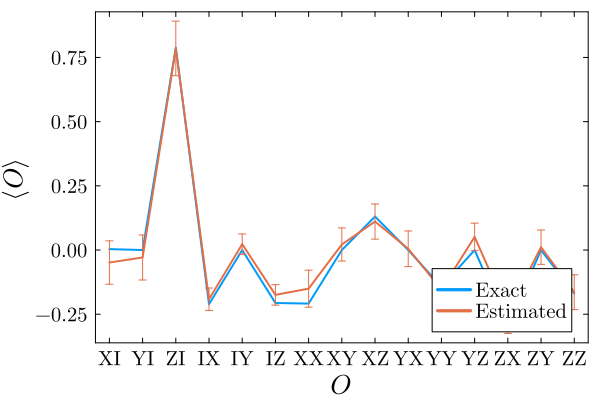

In [12]:

Plots.plot(1:n_op,exact_val,label="Exact")
labels = [op[1]*op[2] for op in op_list]
xticks=(1:n_op, labels)

plot!(1:n_op,mean_val,yerr=2*sem_val, msc = 2,label="Estimated",xticks=xticks,legend=:bottomright)
xlabel!(L"$O$")
ylabel!(L"$\langle O \rangle$")

### Purity estimation

Lastly, we can also estimate non-linear functions of the density matrices such as the purity of the reduced density matrix of subsystem defined by qubits 1 and 4. For this, we also use the reduced measurement data set and the corresponding dense classical shadows.

In [13]:
mean_val, sem_val = get_trace_moment(reduced_classical_shadows,2,compute_sem = true);
ρ = reduce_to_subsystem(ψ,[1,4])
exact_val = get_trace_moment(ρ,2);

println("Estimated purity of ρ = $(round(mean_val, digits=2)) ± $(round(sem_val, digits=2))")
println("Exact purity of ρ = $(round(exact_val, digits=2))")

Estimated purity of ρ = 0.45 ± -0.0
Exact purity of ρ = 0.48


### Higher order trace moments and batch classical shadows

When accessing higher order trace moments, grouping the shadows into batch classical shadows allows us to fasten drastically the estimation from U-statistics

In [14]:
n_max = 5 # we will access tr(rho^n) for n=2,..,6
number_of_ru_batches = 10 #number of batchs
batch_shadows = get_dense_shadows(reduced_group; number_of_ru_batches = number_of_ru_batches)
mean_val, bias, cov = get_trace_moments(batch_shadows, collect(2:n_max), compute_cov=true);
sem_val = [sqrt(cov[i,i]) for i in 1:n_max-1]
exact_val = get_trace_moments(ρ,collect(2:n_max))

4-element Vector{Float64}:
 0.47622849611723883
 0.2648580082834559
 0.15599904901410425
 0.09441046573349327

[0.021635942952105643, 0.019564891598841547, 0.01504575764457985, 0.010945408445700423]

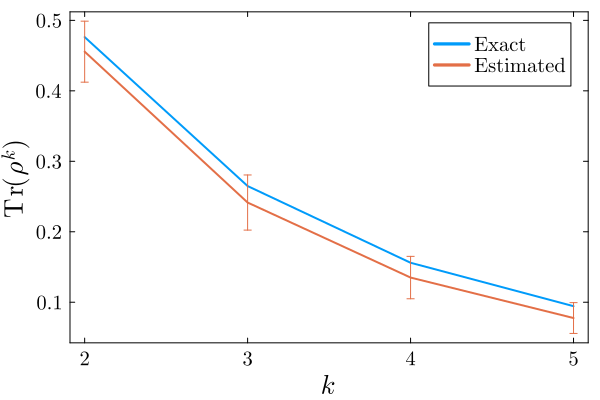

In [15]:
using Plots
using LaTeXStrings
plot(2:n_max,exact_val,label="Exact")
print(sem_val)
plot!(2:n_max,mean_val,yerr=2*sem_val, msc = 2,label="Estimated")
xlabel!(L"$k$")
ylabel!(L"$\mathrm{Tr}(\rho^k)$")
